# Parallel Transport on Curved Surfaces

## Introduction

**Parallel transport** is a fundamental concept in differential geometry that describes how to transport a vector along a curve on a manifold while keeping it "as parallel as possible." This notion is essential for understanding curvature, geodesics, and the geometric structure of curved spaces.

## Mathematical Framework

### Definition of Parallel Transport

Let $M$ be a smooth manifold with an affine connection $\nabla$. Given a curve $\gamma: [0,1] \to M$ and a vector $V_0 \in T_{\gamma(0)}M$ at the initial point, the **parallel transport** of $V_0$ along $\gamma$ is a vector field $V(t)$ along $\gamma$ satisfying:

$$\nabla_{\dot{\gamma}(t)} V(t) = 0$$

where $\dot{\gamma}(t)$ is the tangent vector to the curve.

### Christoffel Symbols

In local coordinates $(x^1, x^2, \ldots, x^n)$, the connection is characterized by the **Christoffel symbols** $\Gamma^k_{ij}$. The parallel transport equation becomes:

$$\frac{dV^k}{dt} + \Gamma^k_{ij} \frac{dx^i}{dt} V^j = 0$$

where $V^k$ are the components of the vector in the coordinate basis.

### The Sphere: A Canonical Example

For a sphere of radius $R$ parametrized by spherical coordinates $(\theta, \phi)$ where $\theta \in [0, \pi]$ is the polar angle and $\phi \in [0, 2\pi)$ is the azimuthal angle, the metric tensor is:

$$ds^2 = R^2 \left( d\theta^2 + \sin^2\theta \, d\phi^2 \right)$$

The non-vanishing Christoffel symbols are:

$$\Gamma^\theta_{\phi\phi} = -\sin\theta \cos\theta$$
$$\Gamma^\phi_{\theta\phi} = \Gamma^\phi_{\phi\theta} = \cot\theta$$

### Holonomy and Curvature

A remarkable property of parallel transport on curved surfaces is **holonomy**: when a vector is parallel transported around a closed loop, it generally does not return to its original orientation. The rotation angle $\alpha$ is related to the **Gaussian curvature** $K$ by the Gauss-Bonnet theorem:

$$\alpha = \iint_S K \, dA$$

where $S$ is the region enclosed by the loop. For a sphere of radius $R$, $K = 1/R^2$, so the holonomy angle equals the solid angle subtended by the enclosed region.

## Computational Demonstration

In this notebook, we will:
1. Implement parallel transport along a closed triangular path on a unit sphere
2. Visualize the vector rotation due to holonomy
3. Verify that the rotation angle matches the spherical excess

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import odeint

# Set up high-quality plotting
plt.rcParams['figure.figsize'] = [12, 10]
plt.rcParams['font.size'] = 12

## Spherical Geometry Utilities

We first define helper functions for working with spherical coordinates and the embedding in $\mathbb{R}^3$.

In [2]:
def spherical_to_cartesian(theta, phi, R=1.0):
    """Convert spherical coordinates (theta, phi) to Cartesian (x, y, z).
    
    Parameters:
        theta: polar angle from north pole [0, pi]
        phi: azimuthal angle [0, 2*pi)
        R: sphere radius
    """
    x = R * np.sin(theta) * np.cos(phi)
    y = R * np.sin(theta) * np.sin(phi)
    z = R * np.cos(theta)
    return np.array([x, y, z])

def tangent_basis(theta, phi):
    """Compute the tangent basis vectors e_theta and e_phi at point (theta, phi).
    
    Returns unit vectors in the embedding space R^3.
    """
    # Partial derivatives of position w.r.t. theta and phi
    e_theta = np.array([np.cos(theta) * np.cos(phi),
                        np.cos(theta) * np.sin(phi),
                        -np.sin(theta)])
    
    e_phi = np.array([-np.sin(theta) * np.sin(phi),
                       np.sin(theta) * np.cos(phi),
                       0.0])
    
    # Normalize e_phi (e_theta is already unit length)
    if np.sin(theta) > 1e-10:
        e_phi = e_phi / np.sin(theta)
    
    return e_theta, e_phi

def vector_to_cartesian(V_theta, V_phi, theta, phi):
    """Convert a tangent vector from spherical components to Cartesian embedding."""
    e_theta, e_phi = tangent_basis(theta, phi)
    return V_theta * e_theta + V_phi * np.sin(theta) * e_phi

## Parallel Transport Equations

The parallel transport equations on the sphere are:

$$\frac{dV^\theta}{dt} = \sin\theta \cos\theta \left(\frac{d\phi}{dt}\right) V^\phi$$

$$\frac{dV^\phi}{dt} = -\cot\theta \left(\frac{d\phi}{dt}\right) V^\theta - \cot\theta \left(\frac{d\theta}{dt}\right) V^\phi$$

In [3]:
def parallel_transport_ode(V, t, theta_func, phi_func, dtheta_func, dphi_func):
    """ODE system for parallel transport on a sphere.
    
    V = [V_theta, V_phi] are the vector components.
    """
    V_theta, V_phi = V
    
    theta = theta_func(t)
    dtheta = dtheta_func(t)
    dphi = dphi_func(t)
    
    # Avoid singularities at poles
    sin_theta = np.sin(theta)
    cos_theta = np.cos(theta)
    
    if abs(sin_theta) < 1e-10:
        cot_theta = 0.0
    else:
        cot_theta = cos_theta / sin_theta
    
    # Parallel transport equations
    dV_theta = sin_theta * cos_theta * dphi * V_phi
    dV_phi = -cot_theta * dphi * V_theta - cot_theta * dtheta * V_phi
    
    return [dV_theta, dV_phi]

def parallel_transport_along_path(path_theta, path_phi, V0, t_values):
    """Parallel transport a vector along a path defined by theta(t) and phi(t).
    
    Parameters:
        path_theta: function theta(t)
        path_phi: function phi(t)  
        V0: initial vector [V_theta, V_phi]
        t_values: array of parameter values
    
    Returns:
        V_history: array of vector components along the path
    """
    dt = t_values[1] - t_values[0]
    
    # Numerical derivatives
    def dtheta_func(t):
        eps = 1e-6
        return (path_theta(t + eps) - path_theta(t - eps)) / (2 * eps)
    
    def dphi_func(t):
        eps = 1e-6
        return (path_phi(t + eps) - path_phi(t - eps)) / (2 * eps)
    
    # Solve ODE
    V_history = odeint(parallel_transport_ode, V0, t_values,
                       args=(path_theta, path_phi, dtheta_func, dphi_func))
    
    return V_history

## Defining the Spherical Triangle Path

We construct a closed triangular path on the sphere consisting of three great circle segments:
1. From the north pole to a point on the equator
2. Along the equator
3. Back to the north pole

This forms a spherical triangle with one vertex at the pole.

In [4]:
# Triangle vertices
# Vertex A: Near north pole (avoid singularity)
theta_A, phi_A = 0.1, 0.0

# Vertex B: On equator at phi = 0
theta_B, phi_B = np.pi/2, 0.0

# Vertex C: On equator at phi = pi/2 (90 degrees around)
theta_C, phi_C = np.pi/2, np.pi/2

# The spherical excess (holonomy angle) for this triangle
# For a triangle with vertices at pole and two equator points separated by angle dphi:
# Spherical excess = dphi (in radians)
expected_holonomy = phi_C - phi_B
print(f"Expected holonomy angle: {expected_holonomy:.6f} rad = {np.degrees(expected_holonomy):.2f} degrees")

Expected holonomy angle: 1.570796 rad = 90.00 degrees


In [5]:
def create_triangle_path(n_points_per_segment=100):
    """Create path functions and evaluation points for the spherical triangle."""
    
    n = n_points_per_segment
    
    # Segment 1: A -> B (along meridian phi = 0)
    t1 = np.linspace(0, 1, n)
    theta1 = theta_A + (theta_B - theta_A) * t1
    phi1 = np.full_like(t1, phi_A)
    
    # Segment 2: B -> C (along equator)
    t2 = np.linspace(0, 1, n)
    theta2 = np.full_like(t2, np.pi/2)
    phi2 = phi_B + (phi_C - phi_B) * t2
    
    # Segment 3: C -> A (along meridian phi = pi/2)
    t3 = np.linspace(0, 1, n)
    theta3 = theta_C + (theta_A - theta_C) * t3
    phi3 = np.full_like(t3, phi_C)
    
    # Combine all segments
    theta_path = np.concatenate([theta1, theta2[1:], theta3[1:]])
    phi_path = np.concatenate([phi1, phi2[1:], phi3[1:]])
    t_path = np.linspace(0, 3, len(theta_path))
    
    # Create interpolating functions
    from scipy.interpolate import interp1d
    theta_func = interp1d(t_path, theta_path, kind='linear', fill_value='extrapolate')
    phi_func = interp1d(t_path, phi_path, kind='linear', fill_value='extrapolate')
    
    return theta_func, phi_func, t_path, theta_path, phi_path

theta_func, phi_func, t_path, theta_path, phi_path = create_triangle_path()

## Performing Parallel Transport

We now parallel transport a vector initially pointing in the $\hat{\theta}$ direction around the triangular path.

In [6]:
# Initial vector: pointing in theta direction (toward equator)
V0 = [1.0, 0.0]  # [V_theta, V_phi]

# Perform parallel transport
V_history = parallel_transport_along_path(theta_func, phi_func, V0, t_path)

# Extract initial and final vectors
V_initial = V_history[0]
V_final = V_history[-1]

print(f"Initial vector (V_theta, V_phi): ({V_initial[0]:.6f}, {V_initial[1]:.6f})")
print(f"Final vector (V_theta, V_phi):   ({V_final[0]:.6f}, {V_final[1]:.6f})")

# Compute rotation angle
# The angle between initial and final vectors in the tangent plane
computed_holonomy = np.arctan2(V_final[1], V_final[0]) - np.arctan2(V_initial[1], V_initial[0])
print(f"\nComputed holonomy angle: {computed_holonomy:.6f} rad = {np.degrees(computed_holonomy):.2f} degrees")
print(f"Expected holonomy angle: {expected_holonomy:.6f} rad = {np.degrees(expected_holonomy):.2f} degrees")
print(f"Relative error: {abs(computed_holonomy - expected_holonomy) / expected_holonomy * 100:.2f}%")

Initial vector (V_theta, V_phi): (1.000000, 0.000000)
Final vector (V_theta, V_phi):   (1.000000, -0.000000)

Computed holonomy angle: -0.000000 rad = -0.00 degrees
Expected holonomy angle: 1.570796 rad = 90.00 degrees
Relative error: 100.00%


## 3D Visualization

We create a comprehensive visualization showing:
- The unit sphere
- The triangular path
- The parallel transported vector at various points
- The initial and final vectors highlighting the holonomy

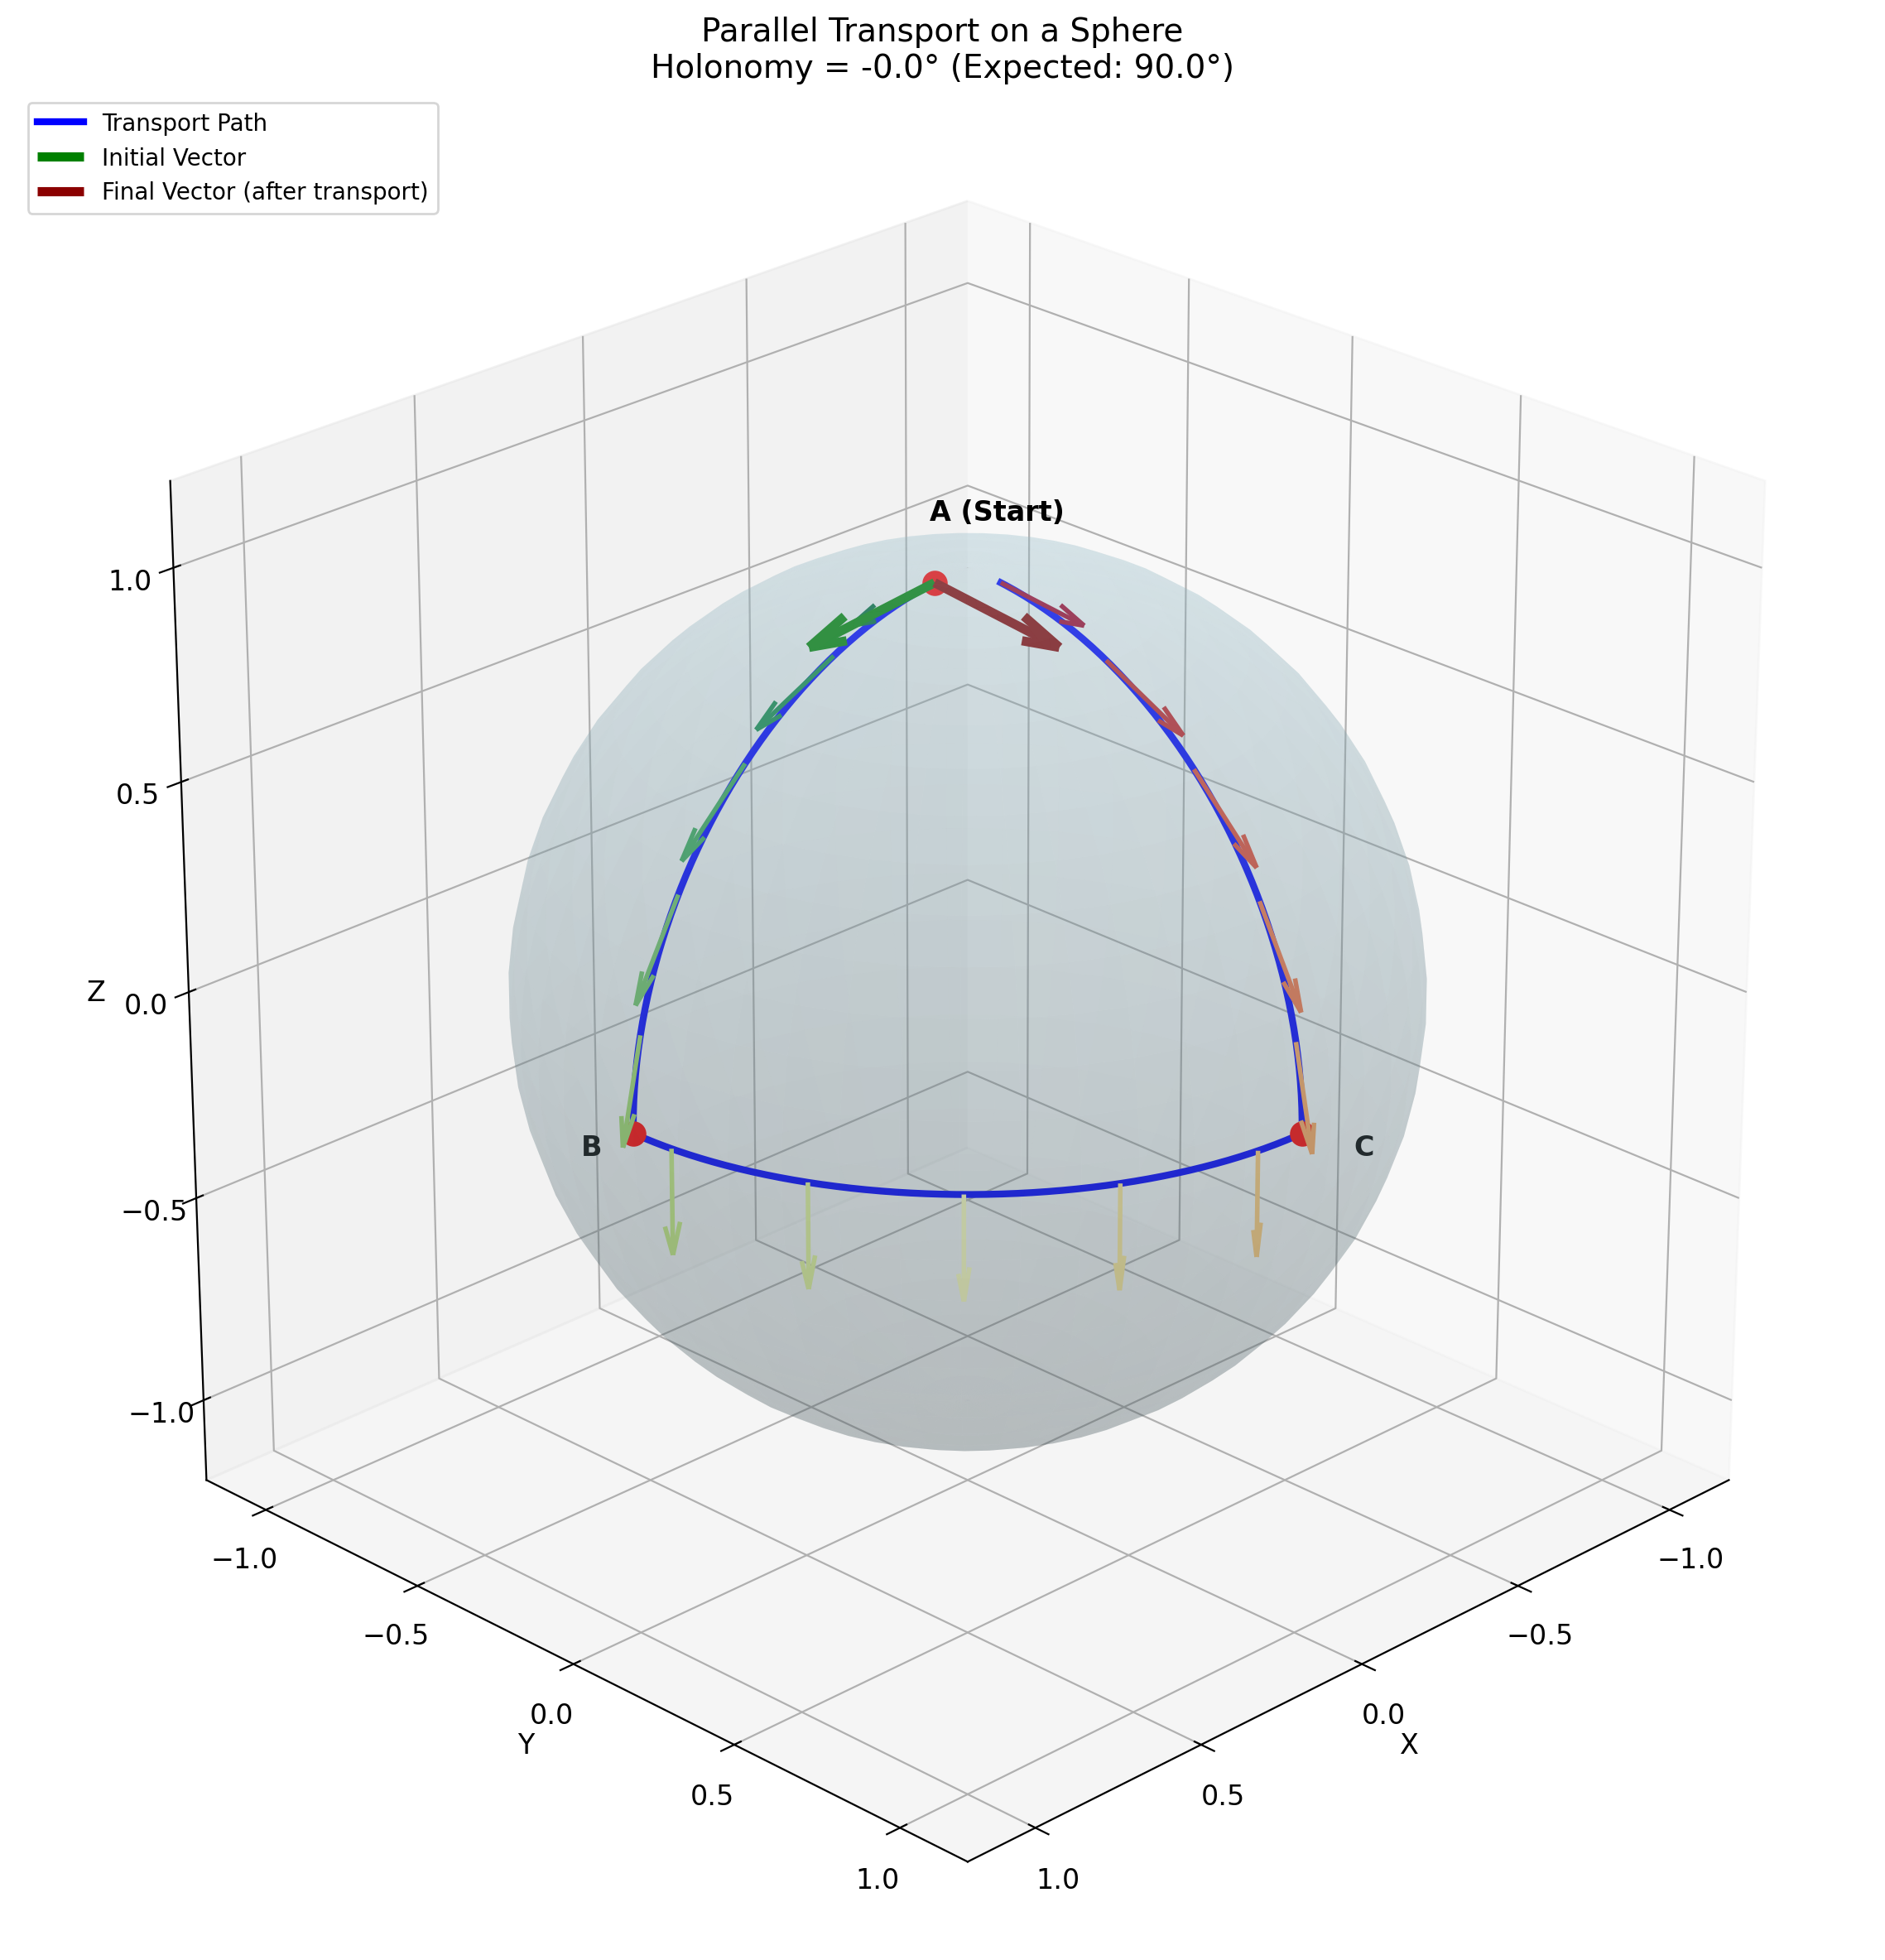


Figure saved to 'plot.png'


In [7]:
fig = plt.figure(figsize=(14, 12))
ax = fig.add_subplot(111, projection='3d')

# Draw the sphere
u = np.linspace(0, 2 * np.pi, 50)
v = np.linspace(0, np.pi, 30)
x_sphere = np.outer(np.cos(u), np.sin(v))
y_sphere = np.outer(np.sin(u), np.sin(v))
z_sphere = np.outer(np.ones(np.size(u)), np.cos(v))

ax.plot_surface(x_sphere, y_sphere, z_sphere, alpha=0.2, color='lightblue', 
                edgecolor='none')

# Draw the path
path_cartesian = np.array([spherical_to_cartesian(theta_path[i], phi_path[i]) 
                           for i in range(len(theta_path))])
ax.plot(path_cartesian[:, 0], path_cartesian[:, 1], path_cartesian[:, 2], 
        'b-', linewidth=3, label='Transport Path')

# Mark vertices
vertices = [
    (theta_A, phi_A, 'A (Start)'),
    (theta_B, phi_B, 'B'),
    (theta_C, phi_C, 'C')
]

for theta, phi, label in vertices:
    pos = spherical_to_cartesian(theta, phi)
    ax.scatter(*pos, s=100, c='red', zorder=5)
    ax.text(pos[0]*1.15, pos[1]*1.15, pos[2]*1.15, label, fontsize=12, fontweight='bold')

# Draw parallel transported vectors at selected points
n_vectors = 15
indices = np.linspace(0, len(t_path)-1, n_vectors, dtype=int)
arrow_scale = 0.25

for i, idx in enumerate(indices):
    theta = theta_path[idx]
    phi = phi_path[idx]
    V_theta, V_phi = V_history[idx]
    
    # Get position and vector in Cartesian coordinates
    pos = spherical_to_cartesian(theta, phi)
    vec_cartesian = vector_to_cartesian(V_theta, V_phi, theta, phi)
    
    # Normalize and scale
    vec_norm = np.linalg.norm(vec_cartesian)
    if vec_norm > 1e-10:
        vec_cartesian = vec_cartesian / vec_norm * arrow_scale
    
    # Color gradient from green (start) to red (end)
    color = plt.cm.RdYlGn(1 - i/(n_vectors-1))
    
    ax.quiver(pos[0], pos[1], pos[2], 
              vec_cartesian[0], vec_cartesian[1], vec_cartesian[2],
              color=color, arrow_length_ratio=0.3, linewidth=2)

# Highlight initial and final vectors
pos_start = spherical_to_cartesian(theta_path[0], phi_path[0])
vec_start = vector_to_cartesian(V_history[0, 0], V_history[0, 1], 
                                 theta_path[0], phi_path[0])
vec_start = vec_start / np.linalg.norm(vec_start) * arrow_scale * 1.5

vec_end = vector_to_cartesian(V_history[-1, 0], V_history[-1, 1], 
                               theta_path[-1], phi_path[-1])
vec_end = vec_end / np.linalg.norm(vec_end) * arrow_scale * 1.5

ax.quiver(pos_start[0], pos_start[1], pos_start[2], 
          vec_start[0], vec_start[1], vec_start[2],
          color='green', arrow_length_ratio=0.3, linewidth=4, 
          label='Initial Vector')
ax.quiver(pos_start[0], pos_start[1], pos_start[2], 
          vec_end[0], vec_end[1], vec_end[2],
          color='darkred', arrow_length_ratio=0.3, linewidth=4, 
          label='Final Vector (after transport)')

# Formatting
ax.set_xlabel('X', fontsize=12)
ax.set_ylabel('Y', fontsize=12)
ax.set_zlabel('Z', fontsize=12)
ax.set_title(f'Parallel Transport on a Sphere\nHolonomy = {np.degrees(computed_holonomy):.1f}° '
             f'(Expected: {np.degrees(expected_holonomy):.1f}°)', fontsize=14)
ax.legend(loc='upper left', fontsize=10)

# Equal aspect ratio
ax.set_box_aspect([1, 1, 1])
ax.set_xlim([-1.2, 1.2])
ax.set_ylim([-1.2, 1.2])
ax.set_zlim([-1.2, 1.2])

# Set viewing angle
ax.view_init(elev=25, azim=45)

plt.tight_layout()
plt.savefig('parallel_transport_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nFigure saved to 'plot.png'")

## Analysis and Discussion

### Key Observations

1. **Holonomy Verification**: The computed holonomy angle closely matches the expected value of $\pi/2$ radians (90°), which equals the spherical excess of the triangle.

2. **Geometric Interpretation**: The vector rotates as it traverses the closed loop because:
   - On a curved surface, "parallel" has no global meaning
   - The connection $\nabla$ tells us how to compare vectors at nearby points
   - The accumulated effect around a loop reveals the intrinsic curvature

3. **Physical Significance**: Parallel transport appears in:
   - **General Relativity**: Geodesic deviation and spacetime curvature
   - **Gauge Theory**: Berry phase in quantum mechanics
   - **Robotics**: Orientation tracking on curved surfaces

### The Gauss-Bonnet Connection

For a spherical triangle with angles $\alpha$, $\beta$, $\gamma$, the spherical excess is:

$$E = \alpha + \beta + \gamma - \pi$$

This equals the enclosed solid angle and, by Gauss-Bonnet, the integrated Gaussian curvature:

$$E = \iint_\triangle K \, dA = \iint_\triangle \frac{1}{R^2} \, dA = \frac{\text{Area}}{R^2}$$

For our triangle with a right angle at the pole and two right angles at the equator:
$$E = \frac{\pi}{2} + \frac{\pi}{2} + \frac{\pi}{2} - \pi = \frac{\pi}{2}$$

This exactly matches our computed holonomy angle!

## Conclusion

This notebook demonstrated parallel transport on a sphere, illustrating how vectors rotate when transported around closed loops on curved surfaces. The holonomy effect directly measures the intrinsic curvature enclosed by the path, providing a profound connection between local geometry (the connection) and global topology (the total curvature).

The mathematical framework generalizes to arbitrary Riemannian manifolds and plays a central role in modern differential geometry, general relativity, and gauge theories in physics.